# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 3:

>- Juan Pablo Baudoin


# Análisis exploratorio

In [1]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
# from pycountry import languages
# from langid.langid import LanguageIdentifier, model

from lib.utils import *
from lib.sim import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# upgrade pip
#! pip install --upgrade pip -q
#! pip install emoji pandarallel matplotlib numpy pandas chardet unidecode
# ! pip install seaborn -q
#! pip install networkx -q
#! pip install langdetect -q
# ! pip install scipy -q
# ! pip install scikit-learn -q



## 1. Lectura de datos

In [3]:
base_name = "filtered_data_2"
src_ds = f"data/{base_name}.csv"
df_ori = pd.read_csv(src_ds)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   signal_id         13913 non-null  int64 
 1   source_posted_at  13913 non-null  object
 2   message_text      13913 non-null  object
 3   commodity         13913 non-null  object
 4   trade_type        13902 non-null  object
 5   username          8867 non-null   object
 6   title             13913 non-null  object
 7   chat_id           13913 non-null  int64 
 8   language          13913 non-null  object
dtypes: int64(2), object(7)
memory usage: 978.4+ KB


In [4]:
df_ori.rename(columns={'username':'telegram_user_id'}, inplace=True)

# Creamos una columna id con el índice de la tabla
df_ori['id_msg'] = df_ori.index


In [5]:
df_ori

,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg
0,34023,2022-05-05 12:16:04+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬S◦C°A˚L°P◦I... STORJUSD...,STORJ,buy,Scalping_300,Scalping_300%,79,es,0
1,34035,2022-07-03 01:56:33+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬S◦C°A˚L°P◦I... VETUSDT ...,VET,buy,Scalping_300,Scalping_300%,79,es,1
2,17390,2022-10-10 01:39:15+00,Pair : BTCUSDT \nLONG\nLeverage : Cross 20x\nE...,BTC,buy,CryptoCashFlowReal,Crypto Cash flow,101,es,2
3,12833,2022-10-16 19:06:39+00,🥇 #OM (Binance)\n\n🎖Buy Range : 205 - 242\n\n🎯...,OM,buy,bitcoinpumpgroup,Bitcoin Pump Group,5,es,3
4,19038,2022-10-07 05:32:36+00,🌹 #NEO/USDT\n\n🟢 LONG\n\n✅ Entry: 8.45-8.28\n\...,NEO,buy,Gtrading7,GLOBAL TRADING 🌍🌍,206,es,4
...,...,...,...,...,...,...,...,...,...,...
13908,1145165,2022-11-02 18:45:49+00,CAPTION: SHORT ⬇️\n\nSHIB1000 USDT\n\nENTRY: 0...,SHIB,buy,BybitItalian,Bybit Italiano,3745,es,13908
13909,1145214,2022-10-29 01:38:18+00,CAPTION: LONG ⬆️\n\nMKR USDT\n\nENTRY: 884.3\n...,MKR,buy,BybitItalian,Bybit Italiano,3745,es,13909
13910,1145295,2022-11-02 17:35:21+00,CAPTION: SHORT ⬇️\n\nSHIB1000 USDT\n\nENTRY: 0...,SHIB,buy,BybitItalian,Bybit Italiano,3745,es,13910
13911,1473076,2022-09-17 02:39:05+00,⚡️ #MATIC/USDT\n\n🟢 Long\n\n💠 LEVERAGE : 20x\n...,MATIC,buy,CoinExGlobalArabic,CoinEx Arabic-تداول الكريبتو بكل سهولة,4041,es,13911


In [6]:
# check if a file exists
import os
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df_ori.to_csv(work_file, index=False)
    df = df_ori.copy()
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])



File data/filtered_data_2_enhanced.csv already exists. Loading it.


## 2. Análisis de datos categóricos y texto
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categóricas: commodity, trade_type, chat_id, telegram_user_id
- Análisis del campo message_text: mediante una inspección de datos muestral se ve que existen varios idiomas, que se tienen múltiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el análisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



In [7]:
# group df by id and count the number of rows
df_grouped_id = df.groupby('signal_id').size().reset_index(name='counts')
# sort the values by counts
df_grouped_id = df_grouped_id.sort_values(by='counts', ascending=False)
df_grouped_id

,signal_id,counts
13912,1473446,1
0,10,1
1,12,1
2,27,1
3,28,1
...,...,...
13,106,1
12,104,1
11,98,1
10,97,1


### 2.1 Nulos

In [8]:
# get the percentage of missing values in the dataset
missing_values = df_ori.isnull().mean() * 100
# sort the columns by the percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columns with missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columns with no missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")

############
Columns with missing values
    telegram_user_id: 36.27%
    trade_type: 0.08%
############
Columns with no missing values
    source_posted_at
    signal_id
    commodity
    message_text
    title
    chat_id
    language
    id_msg


In [9]:
# Excluir los registros sin chat_id
df = df.dropna(subset=['chat_id'])
df = df.dropna(subset=['message_text'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13913 non-null  datetime64[ns, UTC]
 11  message_text_clean       139

## Filtado de mensajes en ingles

In [10]:
# List the languages in the datase language column
languages = df['language'].unique()
print(languages)


['es']


In [11]:
# filter the messages with language 'en'
# flt_en = df['language'] == 'en'
flt_en = df['language'] == 'es'
df = df[flt_en]

print(f"Numero de mensajes en ingles: {df.shape[0]}")

Numero de mensajes en ingles: 13913


### 2.2. Frecuencias simples

#### 2.2.1. Top 10 de conteos

In [12]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - BTC: 557 	 (4.0% - 4.00%)
02 - ETH: 388 	 (2.79% - 6.79%)
03 - LTC: 235 	 (1.69% - 8.48%)
04 - BNB: 218 	 (1.57% - 10.05%)
05 - DYDX: 214 	 (1.54% - 11.59%)
06 - TRX: 213 	 (1.53% - 13.12%)
07 - GALA: 194 	 (1.39% - 14.51%)
08 - AXS: 181 	 (1.3% - 15.81%)
09 - YFI: 173 	 (1.24% - 17.05%)
10 - MATIC: 163 	 (1.17% - 18.22%)
11 - MASK: 162 	 (1.16% - 19.38%)
--------
Top 11 Canal (chat_id):
01 - 79: 2599 	 (18.68% - 18.68%)
02 - 169: 2409 	 (17.31% - 35.99%)
03 - 101: 1427 	 (10.26% - 46.25%)
04 - 5: 1134 	 (8.15% - 54.40%)
05 - 180: 870 	 (6.25% - 60.65%)
06 - 71: 723 	 (5.2% - 65.85%)
07 - 2131: 440 	 (3.16% - 69.01%)
08 - 78: 416 	 (2.99% - 72.00%)
09 - 66: 378 	 (2.72% - 74.72%)
10 - 206: 290 	 (2.08% - 76.80%)
11 - 2269: 283 	 (2.03% - 78.83%)
--------
Top 11 Users (telegram_user_id):
01 - N/A: 5046 	 (36.27%  - 36.27%) 	 (NaN)
02 - Scalping_300: 2599 	 (18.68%  - 54.95%) 	 (W/NaN 29.31% - 29.31%)
03 - CryptoCashFlowReal: 1427 	 (10.26%  - 65.21%) 	 

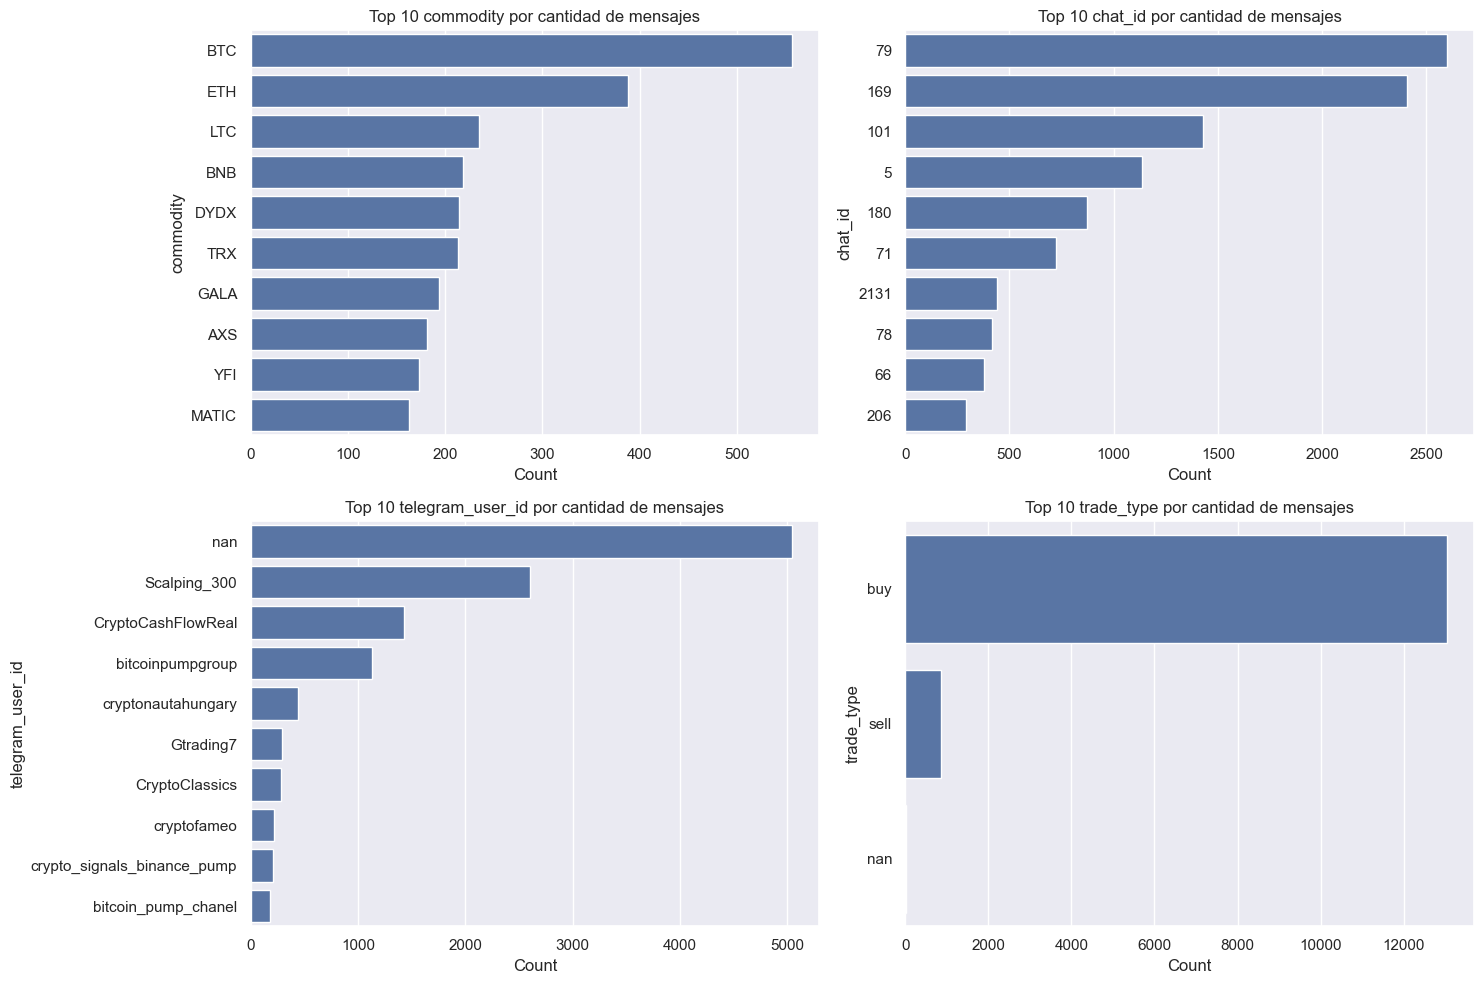

In [13]:
columns_to_plot = ['commodity', 'chat_id', 'telegram_user_id', 'trade_type']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    value_counts = df[column].astype(str).value_counts(dropna=False).head(10)
    
    # Convert value_counts to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    # Create the barplot
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 {column} por cantidad de mensajes')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2.2.2. Cruce de variables `telegram_user_id` y `chat_id`

In [14]:
# count the number of chat_ids
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

# count the number of users
users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")



Number of chat_ids: 128
Number of users: 110


In [15]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()} ({single_user_chats.count()/chat_ids:.2%})")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()} ({single_chat_users.count()/users:.2%})")


# Distribucion de numero de mensajes por canal


Number of chats with a single user: 110 (85.94%)
Number of users with a single chat: 110 (100.00%)


In [16]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 0
Number of chats with more than one user: 0.00%
Series([], Name: telegram_user_id, dtype: int64)
--------
Number of users with more than one chat: 0
Number of users with more than one chat: 0.00%
Series([], Name: chat_id, dtype: int64)


### 2.3. Análisis del campo message_text
#### 2.3.1. Limpieza de datos y enriquecimiento simple

Para continuar con el análisis exploratorio, como indicamos antes, necesitamos realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo
    - Clean emojis: Remover los emojis
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8


In [17]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break

    # df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply
    # (lambda x: '\n'.join(line.strip() for line in x.splitlines() if line.strip()))

    try:
        cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    except Exception as e:
        print(text, type(text))
        print(e)
        cleaned_text = text
        raise e
    return cleaned_text
    

In [18]:
force_process = False

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################

    # Eliminar emojis y añadir columna message_no_emoji
    print("Cleaning Emojis")
    df['message_text_clean'] = df['message_text'].parallel_apply(remove_emojis).str.strip().str.lower()

    # # Detect the encoding of messages in the field message_text_clean of type string\
    print("Detecting encoding")
    df['message_encoding'] = df['message_text_clean'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Limpieza sobre el encoding utf8 ###
    #######################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    print("Convert to utf-8")
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    # print("Detecting encoding on new utf-8 messages")
    # df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Trim and remove multiple line breaks
    print("Cleaning LBR")
    df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply(clean_lbr)

    # Añadir columna con la longitud del mensaje sin emojis
    print("Checking message length")
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    print("Checking message words")
    df['message_words'] = df['message_text_clean_utf8'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df['message_lbr'] = df['message_text_clean_utf8'].parallel_apply(count_line_breaks)

    print("Store the processed data")
    df.to_csv(work_file, index=False)


In [19]:
# find messages with a length of 0
zero_length = df['message_length'] == 0
print(f"Number of messages with a length of 0: {zero_length.sum()}")

# drop messages with a length of 0
df = df[~zero_length]
df.to_csv(work_file, index=False)


Number of messages with a length of 0: 0


#### 2.3.3. Mensajes duplicados

In [20]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 7341
Percentage of duplicated messages: 52.76%
--------


In [21]:
duplicated_messages.head(5)['id_msg']

595      4720
600      6022
8809     2428
8810     8611
8987    12850
Name: id_msg, dtype: int64

Si vemos mensajes duplicados en una ventana pequeña de tiempo podemos asumir que son el mismo mensaje y quedarnos con uno.

In [22]:
# repeated_window
repeated_window = 1 # Window where to consider repeated messages within the same chat_id a repeated messaged

df = df.sort_values(by=['chat_id', 'message_text_clean_utf8', 'date_source_posted_at'])

# Group by chat_id and find the time difference between consecutive messages
# df['time_diff'] = df.groupby('chat_id', 'message_text_clean_utf8')['date_source_posted_at'].diff()
df['time_diff'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['date_source_posted_at'].diff( )


# Mark duplicates as those with a time difference less than 5 minutes (300 seconds) and the same message text
df['duplicates'] = df['message_text_clean_utf8'].duplicated(keep=False)
df['duplicate_count'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['id_msg'].transform('count')
df['duplicates_near'] = (df['time_diff'] <= pd.Timedelta(minutes=repeated_window)) & (df['message_text_clean_utf8'].duplicated(keep='first'))
# df['duplicates_near2'] = ((df['time_diff'].dt.total_seconds()/60) <= repeated_window) & (df['message_text_clean_utf8'].duplicated(keep='first'))


cols_check = ['chat_id', 'date_source_posted_at', 'message_text_clean_utf8', 'time_diff', 'duplicates', 'duplicates_near', 'duplicate_count']


# Keep only the first message in the case of duplicates
# df_filtered = df[~df['duplicate']]

# Drop helper columns if not needed
# df_filtered = df_filtered.drop(columns=['time_diff', 'duplicate'])

# count the number of duplicates_near
duplicates_near = df['duplicates_near'].sum()
print(f"Number of duplicates_near: {duplicates_near}")
print(f"Percentage of duplicates_near: {duplicates_near/df.shape[0]:.2%}")

flt_duplicates = df['duplicates']
df[flt_duplicates][cols_check].sort_values(by=['chat_id', 'message_text_clean_utf8', 'date_source_posted_at']).head(600).tail(10)

Number of duplicates_near: 3385
Percentage of duplicates_near: 24.33%


,chat_id,date_source_posted_at,message_text_clean_utf8,time_diff,duplicates,duplicates_near,duplicate_count
5571,79,2022-11-16 13:10:31+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... axsusdt ......,0 days 00:00:01,True,True,2
5174,79,2022-11-02 07:00:40+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... axsusdt ......,NaT,True,False,2
5177,79,2022-11-02 07:00:44+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... axsusdt ......,0 days 00:00:04,True,True,2
4737,79,2022-10-09 06:00:48+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,NaT,True,False,2
4758,79,2022-10-09 06:00:56+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,0 days 00:00:08,True,True,2
4632,79,2022-10-02 03:05:37+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,NaT,True,False,2
4642,79,2022-10-02 03:05:47+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,0 days 00:00:10,True,True,2
5353,79,2022-11-09 13:00:46+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,NaT,True,False,2
5366,79,2022-11-09 13:00:55+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,0 days 00:00:09,True,True,2
5817,79,2022-11-29 01:59:44+00:00,SCALPING 300 ]\ns*cdega@ldegp*i... balusdt ......,NaT,True,False,2


In [23]:
# Remove duplicates_near
df = df[~df['duplicates_near']]



work_file = f"data/{base_name}_enhanced_nodup.csv"
df.to_csv(work_file, index=False)

#### 2.3.4. Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

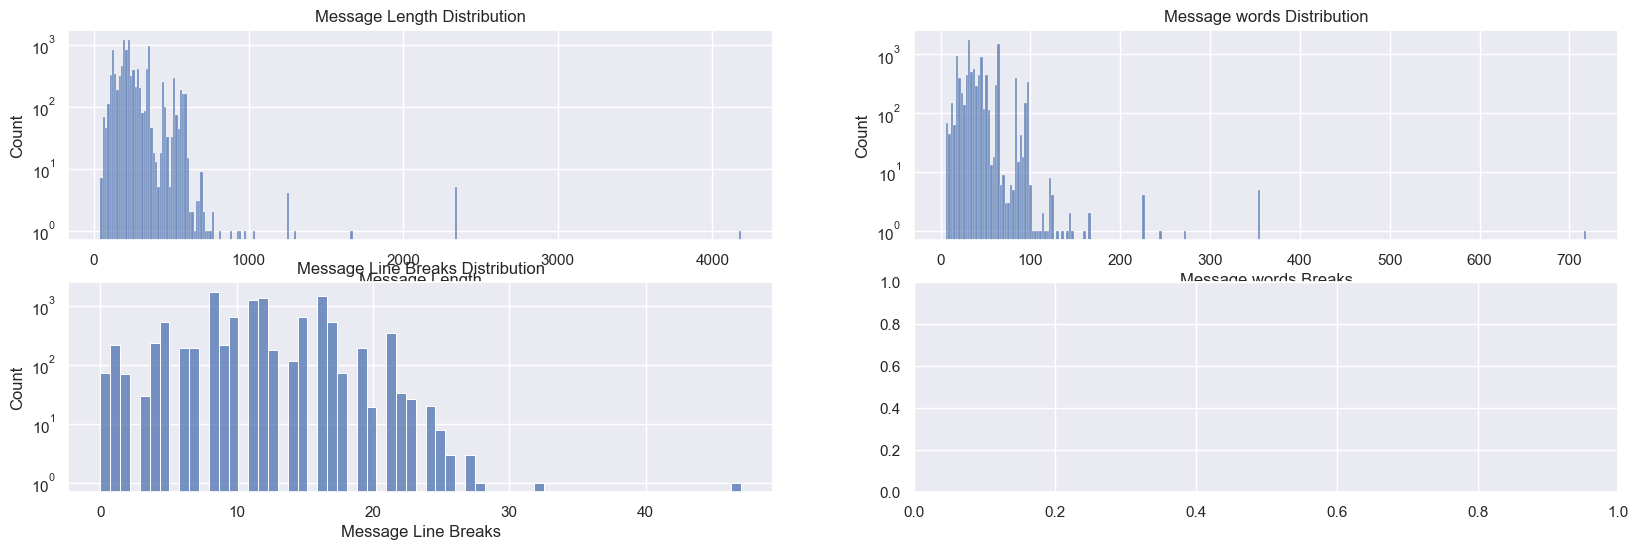

In [24]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado. Vemos que existen outliers en todas las distribuciones, los cuales podríamos analizar en más detalle.

In [25]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,10528.000000,10528.000000,10528.000000
mean,266.318199,44.719605,11.519377
std,143.568089,24.094271,4.674633
min,42.000000,6.000000,0.000000
25%,187.000000,31.000000,8.000000
50%,222.000000,38.000000,11.000000
75%,348.000000,61.000000,16.000000
max,4185.000000,719.000000,47.000000


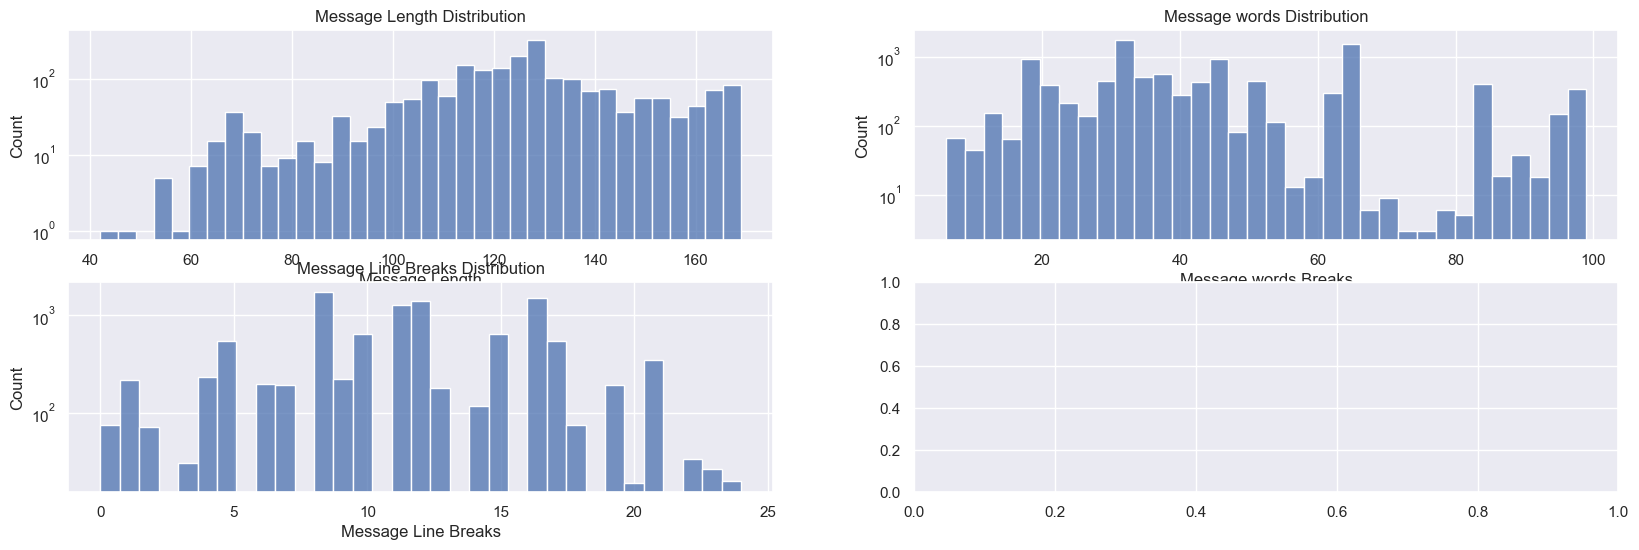

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

flt_mbr = (df['message_lbr'] < 25) & (df['message_lbr'] >= 0) 
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

In [27]:
print_top(df, 'message_lbr', "LBR", top=5)

Top 5 LBR (message_lbr):
01 - 8: 1740 	 (16.53% - 16.53%)
02 - 16: 1504 	 (14.29% - 30.82%)
03 - 12: 1385 	 (13.16% - 43.98%)
04 - 11: 1281 	 (12.17% - 56.15%)
05 - 10: 640 	 (6.08% - 62.23%)


In [28]:
print_top(df, 'message_words', "Words", top=5)

Top 5 Words (message_words):
01 - 64: 1428 	 (13.56% - 13.56%)
02 - 32: 1196 	 (11.36% - 24.92%)
03 - 46: 828 	 (7.86% - 32.78%)
04 - 19: 554 	 (5.26% - 38.04%)
05 - 38: 467 	 (4.44% - 42.48%)


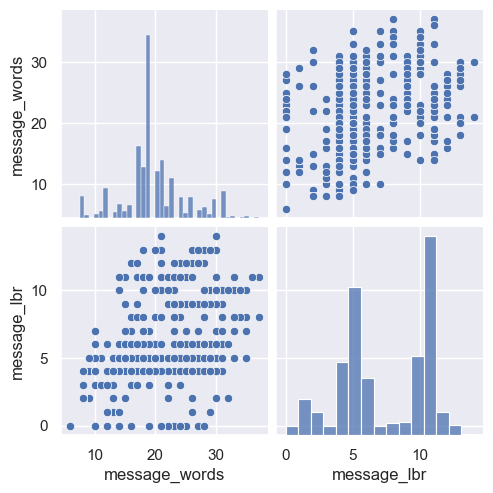

In [29]:
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_words', 'message_lbr']])
plt.show()

## Preprocesamiento vectorización

Para la comparación de mensajes es necesario vectorizar los mismos, este proceso requiere de una limpieza de datos adicional.

In [30]:
# Instalación de las bibliotecas necesarias
import os
import nltk
# import spacy
import pandas as pd
import re
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [31]:
df_sim = df

In [32]:
def create_word_bins(df, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                               10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                               20, 21, 22, 23, 24, 25, 26, 27, 28, 29, np.inf]):
    """
    Function to bin the word count into categories.
    You can modify 'bins' based on your use case.
    """
    # Create a new column 'word_bin' based on the number of words
    df['word_bin'] = pd.cut(df['message_words'], bins=bins, labels=False, right=False)
    return df

In [33]:

stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess(text, stop_words=stop_words):

    text = text.lower()
    # tokenizar el texto
    text = text.replace('\n', ' LBRMARK ')

    
    text_tokens = word_tokenize(text)
    # replace numbers with a placeholder
    # print(text_tokens)
    text_tokens_rst = text_tokens.copy() 
    i = -1
    for token in text_tokens:
        i += 1
        token = re.sub(r'\s+', ' ', token)

        # if token in stop_words:
        #     # remove the token from the list
        #     text_tokens_rst.pop(i)
        #     i -= 1
        #     # text_tokens_rst[i] = '{STOP_WORD}'
        #     continue

        if is_number(token):
            text_tokens_rst[i] = '{NUM}'
            continue

        if is_date(token):
            text_tokens_rst[i] = '{DATE}'
            continue

        tmp_token = re.sub(r'[^a-zA-Z0-9@\s]', ' ', token)  # eliminar caracteres especiales
        if tmp_token == token:
            continue
        text_tokens_rst[i] = preprocess(tmp_token)

    text = ' '.join(text_tokens_rst)
    # print(text)

    # text = re.sub(r'[^a-zA-Z0-9@\s]', ' ', text)  # eliminar caracteres especiales
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # print(text)

    text = text.replace(' LBRMARK ', '\n')
    text = text.replace('LBRMARK', '\n')
    text = clean_lbr(text)
    return text


# df['tokenized_nltk'] = df['cleaned'].apply(word_tokenize)

# aclarar que se usa un dataset expandido
# Evolucion temporal con los meses con más mensajes
# conteo de users y chat_ids
# Mensajes por tipo de operación




In [34]:
# nltk.download('punkt_tab')


In [35]:
force_process = True

if 'cleaned_sim' not in df_sim.columns or force_process:
    df_sim.rename(columns={'message_lbr': 'message_lbr_utf8'}, inplace=True)
    df_sim.rename(columns={'message_words': 'message_words_utf8'}, inplace=True)

    print("Cleaning messages")
    # # apply preprocess to the messages df_sim['message_text_clean_utf8']
    df_sim['cleaned_sim'] = df_sim['message_text_clean_utf8'].apply(preprocess)

    # Añadir columna con el número de palabras
    print("Checking message words")
    df_sim['message_words'] = df_sim['cleaned_sim'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df_sim['message_lbr'] = df_sim['cleaned_sim'].parallel_apply(count_line_breaks)

    print("Creating word bins")
    df_sim = create_word_bins(df_sim)



Cleaning messages
Checking message words
Checking message LBRs
Creating word bins


In [36]:
print("Store the processed data")
work_file = f"data/{base_name}_pre-processed.csv"
df_sim.to_csv(work_file, index=False)


Store the processed data
